# investigating the alignment stage based on taking a number of true clusters


In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from random import shuffle
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
#from skbio.alignment import local_pairwise_align_ssw
#from skbio import DNA
from include import *
import itertools
import operator
import time

In [5]:
# Read data
orig_seqs = file_to_list("data/File1_ODNA.txt")
filename = "data/I16_S2_R1_001.fastq"
seqs = fastq_to_list(filename)

## randomly take 2 million sequences

In [6]:
print("all sequences: ", len(seqs))
print("all orig sequences: ", len(orig_seqs))
seqs = [seq for seq in seqs if len(seq) >= 55 and len(seq) <= 65]
print("all long sequences: ",  len(seqs))
# random sample the space
sample_size = int(2e6)
indeces = np.ndarray.tolist(np.random.randint(0,len(seqs),size=(1,sample_size)))[0]
seqs = [seqs[i] for i in indeces]

all sequences:  29303855
all orig sequences:  16383
all long sequences:  11083592


In [7]:
def fraction_recovered(candidates,orig_seqs):
    d = {}
    for seq in orig_seqs:
        d[seq] = 0
    for cand in candidates:
        if cand in d:
            d[cand] += 1
    av = sum([ d[seq]>0 for seq in d]) / len(d)
    print("Fraction of recovered sequences: ", av )
    if av>0:
        print("Fraction of recovered sequences: ", sum([ d[seq] for seq in d]) / len(d) / av )

## True Clustering
Finding true clusters corresponding to 100 randomly-chosen centers

In [8]:
from Bio import pairwise2

inds = np.random.permutation(len(orig_seqs))
orig_100 = []
for ind in inds:
    orig_100 += [orig_seqs[ind]]
    if len(orig_100) == 100:
        break
true_clusters_100 = []

def edit_dist(u,v):
    ma = pairwise2.align.globalxx(u,v,one_alignment_only=1)
    ctr = 0
    for i in range(len(ma[0][0])):
        if ma[0][0][i] != ma[0][1][i]:
            ctr += 1
    return ctr

for i,orig in enumerate(orig_100):
    cluster = []
    s = time.time()
    for seq in seqs:
        score = edit_dist(orig,seq)
        if score<10:
            cluster += [seqs.index(seq)]
    
    if i%10==0:
        print("%",i*100/len(orig_100),time.time()-s,'seconds')
    true_clusters_100 += [cluster]

% 0.0 577.2136945724487 seconds
% 10.0 577.2878429889679 seconds
% 20.0 574.9603912830353 seconds
% 30.0 605.6465382575989 seconds
% 40.0 592.8079161643982 seconds
% 50.0 593.9639930725098 seconds
% 60.0 573.1772012710571 seconds
% 70.0 583.3907463550568 seconds
% 80.0 577.6345634460449 seconds
% 90.0 577.0847451686859 seconds


In [10]:
# how many clusters have more than 3 members? take those to work on
ct= 0
pool = []
true_clusters = []
originals = []
for i,c in enumerate(true_clusters_100):
    if len(c)>3:
        true_clusters += [c]
        originals += [orig_100[i]]
        pool += [seqs[ind] for ind in c]
        ct += 1
print(ct) # the number of centers we get to work on

65


4


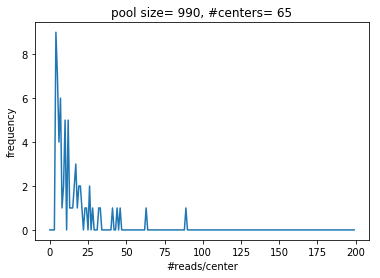

In [22]:
M = 10
for c in true_clusters:
    if len(c)<M:
        M = len(c)
print(M)
l,nuc,n = seq_stats(true_clusters)
plt.plot(l)
plt.title("pool size= "+str(len(pool))+", "+"#centers= "+str(len(originals)))
plt.ylabel("frequency")
plt.xlabel("#reads/center")
plt.show()

In [13]:
true_results = []

def align_clusters(clusters,masize = 15):
    ### align clusters, generate candidates
    s = time.time()
    for i, clusterinds in enumerate(clusters):
        cluster = [seqs[i] for i in clusterinds]
        if len(cluster)<=3:
            continue
        if len(cluster) > masize:
            for j in range(5):
                shuffle(cluster)
                ma = multiple_alignment(cluster[:masize])
                true_results.append(ma)
                
        else:
            ma = multiple_alignment(cluster[:masize])
            true_results.append(ma)
            
        if i % 10 == 0:
            print("time",time.time()-s)
            print(i/len(clusters))
            s = time.time()
            #fraction_recovered( [seq[:60] for seq in results] , originals)

s = time.time()
align_clusters(true_clusters)
print("Alignment Runtime:",time.time()-s)

time 0.15916848182678223
0.0
time 2.797642707824707
0.15384615384615385
time 4.13331151008606
0.3076923076923077
time 4.202159881591797
0.46153846153846156
time 5.521548748016357
0.6153846153846154
time 3.434147834777832
0.7692307692307693
time 2.212012767791748
0.9230769230769231
Alignment Runtime: 24.96064567565918


Fraction of recovered sequences:  0.4461538461538462
Fraction of recovered sequences:  1.482758620689655
max_length 15 min_length 4


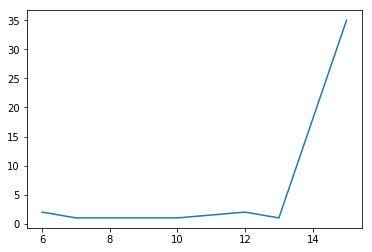

In [14]:
import operator
len_recov = {}
def majority_merge(reads,weight = 0.4):  
    # assume reads have the same lenght
    res = ""
    for i in range(len(reads[0])):
        counts = {'A':0,'C':0,'G':0,'T':0,'-':0,'N':0}
        for j in range(len(reads)):
            counts[reads[j][i]] +=1
        counts['-'] *= weight
        mv = max(counts.items(), key=operator.itemgetter(1))[0]
        if mv != '-':
            res += mv
    if res[:60] in originals:
        if len(reads) in len_recov:
            len_recov[len(reads)] += 1
        else:
            len_recov[len(reads)] = 1
    return res

m = 15 # find minimum length of clusters
M = 15   # maximum length of clusters
candidates = []
for ma in true_results:
    if len(ma)<m:
        m = len(ma)
    res = majority_merge(ma,weight=0.5) # 0.45
    candidates.append(res)
fraction_recovered( [seq[:60] for seq in candidates] , originals)

lenlist = list(len_recov.items())
lenlist.sort()
x = [a[0] for a in lenlist]
y = [a[1] for a in lenlist]
plt.plot(x,y)
print('max_length',M,'min_length',m)

the above plot shows the number of centers recovered based on length of the clusters (the number of elements each of them have).
for example, given clusters with length 15, 35 centers were recovered based on them

In [86]:
print(len(candidates))      # number of candidates
print(len(set(candidates))) # number of candidates after throwing redundant ones away

44


41

## counting errors, erasures, and check the inequality

In [21]:
# cluster candidates based on their indices
cand_clust = {}
for c in candidates:
    if c[60-18:60-6] in cand_clust:
        cand_clust[c[60-18:60-6]] += [c[:60]]
    else:
        cand_clust[c[60-18:60-6]] = [c[:60]]
print(len(cand_clust),"many indices exist in the candidates")
orig_cand_clust = {}
for i,orig in enumerate(originals):
    if orig[60-18:60-6] in cand_clust:
        orig_cand_clust[orig] = cand_clust[orig[60-18:60-6]]
print(len(orig_cand_clust),'of 65 centers have index among candidates')

# find the most frequent one in each cluster
ind_recovs = orig_cand_clust
for orig in ind_recovs:
    LIST = ind_recovs[orig]
    ind_recovs[orig] = max(set(LIST),key = LIST.count)

erasures = len(originals)-len(ind_recovs)
errors = 0
for orig in ind_recovs:
    if len(orig)!=len(ind_recovs[orig]):
        errors += 1
    else:
        for i in range(60):
            if orig[i]!=ind_recovs[orig][i]:
                errors += 1
                break
print("errors:",errors)
print("erasures:",erasures)
condition = 2*errors+erasures
print("2*(#errors) + #erasures:",condition)
print("does the inequality hold?",condition<=0.25*len(originals))

113 many indices exist in the candidates
32 of 65 centers have index among candidates
errors: 6
erasures: 33
2*(#errors) + #erasures: 45
does the inequality hold? False
